In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm
import time

In [26]:
dataloader = utils.MRIDataLoader()

In [27]:
subject_id_default = 13620
subject_ids = dataloader.get_subject_ids()
mri_data = dataloader.get_img(subject_id_default, 'signal')
seg_data = dataloader.get_img(subject_id_default, 'seg')
TE_times = dataloader.get_TE_times()
roi_dict, roi_id_dict = dataloader.get_roi_dicts()
thresh_default = 0.9
slice_default=25

In [28]:
problem_one_compartment = utils.create_problem_to_minimize('one_compartment')
problem_two_compartment = utils.create_problem_to_minimize('two_compartment')
problem_two_v_compartment = utils.create_problem_to_minimize('two_compartment_v')

rois = ['WM', 'GM', 'CSF']

### Fit 4 models on 200 voxels 100 times perturbing the starting conditions each time. Calculate the number of times the global minimum is hit (assuming it is found once)

In [29]:
answers = []
timings = []
nb_rand = 200
nb_repeat = 100

rois = ['WM', 'GM', 'CSF']
problems = [{'model': utils.model_one_compartment, 'name': 'linear_least_squares'},
            {'model': utils.model_one_compartment,   'problem': problem_one_compartment,   'bounds': None, 'x0': np.array([5000, 50]), 'name': 'one_compartment'},
            {'model': utils.model_multi_compartment, 'problem': problem_two_compartment,   'bounds': None, 'x0': np.array([5000, 50, 60]), 'name': 'two_compartment'},
            {'model': utils.model_multi_compartment, 'problem': problem_two_v_compartment, 'bounds': None, 'x0': np.array([5000, 50, 60, 0.8]), 'name': 'two_compartment_v'}]
seg = seg_data[:,:,slice_default].reshape((-1,6))
data = mri_data[:,:,slice_default].reshape((-1,10))
is_mono = utils.is_monotonic_index(data)
is_solve = seg[:,0]
is_mono_solve = (is_mono * is_solve).astype(bool)
data_is_mono = data[is_mono_solve]
seg_is_mono = seg[is_mono_solve]
rand_vox_id = np.random.randint(low=0, high=is_mono_solve.sum(), size=nb_rand)
data = data_is_mono[rand_vox_id]
seg = seg_is_mono[rand_vox_id]

for i, problem_dict in enumerate(problems):
    answers.append([])
    timings.append([])
    if problem_dict['name'] == 'linear_least_squares':
        
        start_time = time.time()
        T2, S0 = utils.lsqr_weighted(data[:,1:], seg[:,0], TE_times[1:])
        timings[i].append(time.time() - start_time)
        for repeat_id in range(nb_repeat):
            answers[i].append([T2, S0, TE_times])
    else:
        model, problem, bound, x0 = problem_dict['model'], problem_dict['problem'], problem_dict['bounds'], problem_dict['x0']
        model_name = problem_dict['name']
        std = x0 / 5
        nb_vox = data.shape[0]
        
        for repeat_id in tqdm(range(nb_repeat)):
            
            X0 = np.random.normal(x0, std, size=(nb_vox, len(x0)))
            # X0 = np.tile(x0, reps=nb_vox).reshape(nb_vox, -1)
        
            args_TE = np.tile(TE_times, reps=nb_vox).reshape(nb_vox, -1)
            
            v0 = seg[:,1:].max(axis=-1)
            v0 = np.where(v0 < 0.5, 0.5, v0)
            v = np.stack([v0, 1-v0], axis=-1)
            
            if model_name == 'one_compartment':
                args = [data[:,1:], args_TE[:,1:]]
            elif model_name == 'two_compartment':
                args = [data[:,1:], args_TE[:,1:], v]
            elif model_name == 'two_compartment_v':
                args = [data[:,1:], args_TE[:,1:]]
                
            start_time = time.time()
            answers_tmp = utils.minimize_given_problem(problem=problem, X0=X0, args_list=args, is_print_progress=False)
            timings[i].append(time.time() - start_time)
        
            if model_name == 'one_compartment':
                S0, T2 = answers_tmp
                answers[i].append([T2, S0, TE_times])
            elif model_name in ['two_compartment', 'two_compartment_given_T']:
                S0, T2_0, T2_1 = answers_tmp
                T2 = np.stack([T2_0, T2_1], axis=-1)
                answers[i].append([T2, S0, TE_times, v])
            elif model_name in ['two_compartment_v', 'two_compartment_v_given_T']:
                S0, T2_0, T2_1, v0 = answers_tmp
                T2 = np.stack([T2_0, T2_1], axis=-1)
                v = np.stack([v0, 1 - v0], axis=-1)
                answers[i].append([T2, S0, TE_times, v])
timings = np.array(timings)
    

c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:76: RuntimeWarning: divide by zero encountered in divide
  T2 = (-1) / X[:,1]
100%|██████████| 100/100 [15:42<00:00,  9.42s/it]
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_26256\520565558.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timings = np.array(timings)


In [30]:
# Calculate the RMSE for all fitted models
N = [2, 2, 3, 4]
rmse_list = []
aic_list = []
for problem_id in range(len(answers)):
    rmse_list.append([])
    aic_list.append([])
    for j in range(len(answers[problem_id])):
        if problem_id == 0:
            model = utils.model_one_compartment
        else:
            model = problems[problem_id]['model']
        signal_est = model(*answers[problem_id][j])
        rmse = utils.RMSE(data, signal_est, dim=-1)
        rmse_list[problem_id].append(rmse)
        aic_mean = utils.AIC(data, signal_est, N[problem_id]).mean()
        aic_list[problem_id].append(aic_mean)
rmse_array = np.array(rmse_list)
aic_array = np.array(aic_list)

c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:96: RuntimeWarning: divide by zero encountered in divide
  T2_inv = 1/T2


linear_least_squares - mean RMSE: 84.36
one_compartment - mean RMSE: 75.74
two_compartment - mean RMSE: 73.34
two_compartment_v - mean RMSE: 68.46

linear_least_squares - best RMSE: 84.36
one_compartment - best RMSE: 75.74
two_compartment - best RMSE: 72.75
two_compartment_v - best RMSE: 65.07

linear_least_squares - AIC: 90.777s
one_compartment - AIC: 90.363s
two_compartment - AIC: 91.599s
two_compartment_v - AIC: 91.359s


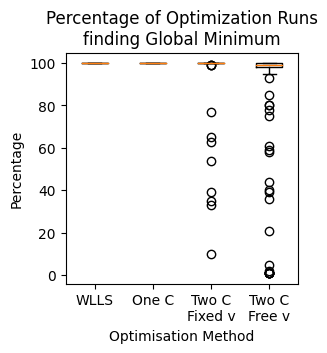

In [43]:
# Average RMSE:
for model_id, problem_dict in enumerate(problems):
    model_name = problem_dict['name']
    print(f'{model_name} - mean RMSE: {rmse_array[model_id].mean():.2f}')    # [p,r,v]
print('')

# best average RMSE
best_rmse = rmse_array.min(axis=1)  # [p,v]
for model_id, problem_dict in enumerate(problems):
    model_name = problem_dict['name']
    print(f'{model_name} - best RMSE: {best_rmse[model_id].mean():.2f}')
print('')

# AIC
for model_id, problem_dict in enumerate(problems):
    model_name = problem_dict['name']
    print(f'{model_name} - AIC: {aic_array[model_id].mean(axis=-1):.3f}s')


rmse_min_same_shape = np.einsum('ij,k->ikj', best_rmse, np.ones(nb_repeat))
nb_global_min = np.isclose(rmse_array, rmse_min_same_shape, rtol=0.1)

fig = plt.figure(figsize=(3,3))
plt.boxplot(nb_global_min.sum(axis=1).swapaxes(0,1), labels=['WLLS', 'One C', 'Two C\nFixed v', 'Two C\nFree v'])
plt.title('Percentage of Optimization Runs\nfinding Global Minimum')
plt.xlabel('Optimisation Method')
plt.ylabel('Percentage')
plt.show()

### Using the two_compartment objective, fit to a slice of MRI and visalise

In [ ]:
data = dataloader.get_img(subject_id_default, 'signal')[:,:,slice_default,:].reshape((-1,10))
seg = dataloader.get_img(subject_id_default, 'seg')[:,:,slice_default,:].reshape((-1,6))

brain_id = roi_dict['brain']
is_solve_for = seg[:,brain_id].astype(bool)
nb_vox = data.shape[0]

x0 = np.array([5000, 50, 60])
X0 = np.tile(x0, reps=nb_vox).reshape(nb_vox, -1)
args_TE = np.tile(TE_times, reps=nb_vox).reshape(nb_vox, -1)

v0 = seg[:,1:].max(axis=-1)
v0 = np.where(v0 < 0.5, 0.5, v0)
v = np.stack([v0, 1-v0], axis=-1)

args = [data[:,1:], args_TE[:,1:], v]

S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args, is_solve_for=is_solve_for, is_print_progress=True)
T2 = np.stack([T2_0, T2_1], axis=-1)

S0 = S0.reshape(96,96)
T2 = T2.reshape(96,96,-1)
data = data.reshape(96,96,-1)
seg = seg.reshape(96,96,-1)
v = v.reshape(96,96,-1)

100%|##########| 9216/9216 [00:35<00:00, 260.54it/s]  


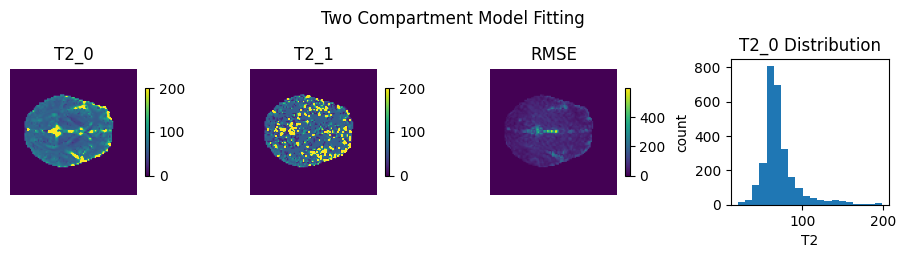

In [ ]:
signal_est = utils.model_multi_compartment(T2, S0, TE_times, v.reshape(96,96,-1))
rmse = utils.RMSE(data, signal_est) * is_solve_for.reshape(96,96)

fig, axs = plt.subplots(1,4, figsize=(9,2.5))
fig.suptitle('Two Compartment Model Fitting')

im = axs[0].imshow(T2[:,:,0], vmax=200)
axs[0].set_title('T2_0')
cbar = fig.colorbar(im, ax=axs[0], shrink=0.6)
axs[0].axis('off')

im = axs[1].imshow(T2[:,:,1], vmax=200)
axs[1].set_title('T2_1')
cbar = fig.colorbar(im, ax=axs[1], shrink=0.6)
axs[1].axis('off')

im = axs[2].imshow(rmse)
axs[2].set_title('RMSE')
cbar = fig.colorbar(im, ax=axs[2], shrink=0.6)
axs[2].axis('off')

t2 = T2.reshape(-1,2)[:,0]
is_show = is_solve_for * (t2 < 200)
t2 = t2[is_show]
axs[3].hist(t2,bins=20)
axs[3].set_title('T2_0 Distribution')
axs[3].set_ylabel('count')
axs[3].set_xlabel('T2')

fig.tight_layout(pad=0.5)